In [ ]:
# @title ⚙️ Runtime & Installs
import os, sys, subprocess, json, math, glob, shutil, random, time
from pathlib import Path

# Check GPU
!nvidia-smi || echo "No NVIDIA GPU detected."

# Install deps (Colab friendly). PaddleOCR uses PaddlePaddle; try GPU first, fallback to CPU if needed.
def pip_install(cmd):
    print(f"Installing: {cmd}")
    subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade", "pip"], check=False)
    subprocess.run([sys.executable, "-m", "pip", "install"] + cmd.split(), check=False)

# Core libs
pip_install("transformers==4.44.2 datasets==3.0.1 seqeval==1.2.2 timm==1.0.7 accelerate==0.34.2 einops pillow opencv-python pycocotools")

# PaddleOCR stack — try GPU build, then CPU if GPU build fails
try:
    print("Trying paddlepaddle-gpu (CUDA 12.x assumed by recent Colab runtimes)...")
    pip_install("paddlepaddle-gpu==2.6.1")
except Exception as e:
    print("GPU paddle install failed, falling back to CPU:", e)
    pip_install("paddlepaddle==2.6.1")

pip_install("paddleocr==2.8.1")

print("✅ Installs attempted. If PaddlePaddle complains about CUDA, restart runtime and rerun.")

Mon Nov  3 05:25:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 1: Fresh unzip from Drive intoclean a  working folder

import os, shutil, zipfile
from pathlib import Path

ZIP_PATH  = "/content/drive/MyDrive/updated/updatefdata.zip"  # your zip on Drive
DEST_DIR  = "/content/finaldata"                       # workspace in Colab

# 1) Clean any previous extraction
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.makedirs(DEST_DIR, exist_ok=True)

# 2) Unzip
assert os.path.exists(ZIP_PATH), f"ZIP not found at: {ZIP_PATH}"
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(DEST_DIR)

# 3) Show top-level contents
print("✅ Unzipped to:", DEST_DIR)
print("Top-level contents:", os.listdir(DEST_DIR)[:50])


✅ Unzipped to: /content/finaldata
Top-level contents: ['notes.json', 'classes.txt', 'images', 'labels']


In [ ]:
# @title 📁 Paths & Basic Config
from pathlib import Path

# 👉 Set these to your dataset on Drive or Colab workspace
BASE_DIR = Path("/content")
IMG_DIR  = Path("/content/finaldata/images")   # ✅ your YOLO export images
OUT_DIR  = BASE_DIR / "exports"                # output folder for JSONL etc.
ANN_PATH = Path("/content/project-14-at-2025-11-03-05-21-11815412.json")         # ✅ your Label Studio export
LABELS_TXT = BASE_DIR / "labels.txt"           # optional label list

# Create output folder
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Split ratios
VAL_RATIO = 0.1
TEST_RATIO = 0.1
RANDOM_SEED = 42

print("IMG_DIR:", IMG_DIR)
print("OUT_DIR:", OUT_DIR)
print("ANN_PATH:", ANN_PATH)
print("LABELS_TXT exists:", LABELS_TXT.exists())


IMG_DIR: /content/finaldata/images
OUT_DIR: /content/exports
ANN_PATH: /content/project-14-at-2025-11-03-05-21-11815412.json
LABELS_TXT exists: False


In [ ]:
# 🧩 Fix for PaddleOCR with NumPy >= 2.0
!pip install numpy==1.26.4 --quiet


In [ ]:
# @title 🔎 Fast OCR (PaddleOCR on GPU if available)
import os, cv2, json
import numpy as np
from paddleocr import PaddleOCR

# Initialize PaddleOCR once
# Use 'use_angle_cls=True' for better orientation robustness.
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)  # set use_gpu=False if issues

def xyxy_to_0_1000(box, W, H):
    # box is 4 points (x,y) for quadrilateral; we convert to min/max box then normalize to [0,1000]
    xs = [p[0] for p in box]
    ys = [p[1] for p in box]
    x0, y0, x1, y1 = max(0, min(xs)), max(0, min(ys)), min(W-1, max(xs)), min(H-1, max(ys))
    # Normalize to 0..1000 integer (LayoutLM expected convention)
    return [
        int(round(x0 / W * 1000)),
        int(round(y0 / H * 1000)),
        int(round(x1 / W * 1000)),
        int(round(y1 / H * 1000)),
    ]

def run_ocr_on_image(img_path: Path):
    image = cv2.imread(str(img_path))
    if image is None:
        return None
    H, W = image.shape[:2]
    res = ocr.ocr(str(img_path), cls=True)
    words, boxes = [], []
    # Paddle returns list per page (for multi-page PDFs); our images are per-page, so take first
    if isinstance(res, list) and len(res) > 0:
        page = res[0]
        for det in page:
            poly, (txt, conf) = det
            if not txt:
                continue
            # filter extreme boxes or empty text
            b = xyxy_to_0_1000(poly, W, H)
            words.append(txt)
            boxes.append(b)
    return dict(words=words, boxes=boxes, size=(W, H))

# Iterate images and write raw OCR JSONL (no labels yet)
raw_jsonl = OUT_DIR / "ocr_pages.jsonl"
count = 0
with raw_jsonl.open("w", encoding="utf-8") as f:
    for ext in ("*.png","*.jpg","*.jpeg","*.tif","*.tiff","*.bmp"):
        for img in sorted(IMG_DIR.glob(ext)):
            rec = run_ocr_on_image(img)
            if not rec or not rec["words"]:
                continue
            out = {
                "id": img.stem,  # page id = filename without extension
                "image_path": str(img),
                "words": rec["words"],
                "bboxes": rec["boxes"],
                "page_size": rec["size"],  # (W,H)
            }
            f.write(json.dumps(out, ensure_ascii=False) + "\n")
            count += 1

print(f"✅ Wrote OCR JSONL with {count} pages:", raw_jsonl)

[2025/11/03 05:27:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

In [ ]:
# @title 📥 Step 1 — Load Label Studio annotations
import json
from pathlib import Path

print("Loading annotations from:", ANN_PATH)

with open(ANN_PATH, "r", encoding="utf-8") as f:
    labelstudio_data = json.load(f)

print(f"✅ Loaded {len(labelstudio_data)} annotation tasks.")

# Show keys in the first record to confirm structure
print("First record keys:", list(labelstudio_data[0].keys()))
print("Has 'file_upload':", 'file_upload' in labelstudio_data[0])
print("Has 'annotations':", 'annotations' in labelstudio_data[0])


Loading annotations from: /content/project-14-at-2025-11-03-05-21-11815412.json
✅ Loaded 1119 annotation tasks.
First record keys: ['id', 'annotations', 'file_upload', 'drafts', 'predictions', 'data', 'meta', 'created_at', 'updated_at', 'inner_id', 'total_annotations', 'cancelled_annotations', 'total_predictions', 'comment_count', 'unresolved_comment_count', 'last_comment_updated_at', 'project', 'updated_by', 'comment_authors']
Has 'file_upload': True
Has 'annotations': True


In [ ]:
# @title 🗺️ Step 2 — Build regions map from Label Studio JSON
from tqdm import tqdm

regions_map = {}

for item in tqdm(labelstudio_data, desc="Parsing annotation pages"):
    if not item.get("annotations"):
        continue

    file_name = item.get("file_upload") or item["data"].get("image", "").split("/")[-1]
    if not file_name:
        continue

    ann = item["annotations"][0]
    results = ann.get("result", [])
    page_regions = []

    for r in results:
        v = r["value"]
        label = v["rectanglelabels"][0]
        ow, oh = r["original_width"], r["original_height"]

        # convert percentage coords to absolute pixels
        x0 = (v["x"] / 100.0) * ow
        y0 = (v["y"] / 100.0) * oh
        x1 = ((v["x"] + v["width"]) / 100.0) * ow
        y1 = ((v["y"] + v["height"]) / 100.0) * oh

        page_regions.append({"category": label, "bbox": [x0, y0, x1, y1]})

    if page_regions:
        regions_map[file_name] = page_regions

print(f"✅ Built mapping for {len(regions_map)} pages with regions.")


Parsing annotation pages: 100%|██████████| 1119/1119 [00:00<00:00, 8643.21it/s]

✅ Built mapping for 1119 pages with regions.


In [ ]:
# @title 🔍 Step 3 — Inspect a random annotated page
import random
import pprint

# pick a random page from the mapping
sample_key = random.choice(list(regions_map.keys()))
sample_regions = regions_map[sample_key]

print(f"📄 Example annotated page: {sample_key}")
print(f"Number of labeled regions: {len(sample_regions)}\n")

# show first few regions nicely formatted
for reg in sample_regions[:5]:
    print(f" • {reg['category']:<15}  bbox={reg['bbox']}")

# optional: pretty print one region for clarity
print("\nFull sample structure:")
pprint.pprint(sample_regions[0])


📄 Example annotated page: 773e851a-resume_457_page_1.png
Number of labeled regions: 5

 • EXPERIENCE       bbox=[944.8092783505157, 976.4536082474227, 2477.2989690721647, 2581.273195876289]
 • EDUCATION        bbox=[922.2061855670103, 2590.314432989691, 2481.0, 2902.237113402062]
 • CONTACT          bbox=[198.90721649484541, 1464.680412371134, 881.5206185567009, 2278.3917525773195]
 • OTHERS           bbox=[904.1237113402061, 2924.8402061855672, 1595.778350515464, 3177.994845360825]
 • PERSONAL_INFO    bbox=[908.6443298969072, 515.3505154639175, 2364.283505154639, 854.3969072164948]

Full sample structure:
{'bbox': [944.8092783505157,
          976.4536082474227,
          2477.2989690721647,
          2581.273195876289],
 'category': 'EXPERIENCE'}


In [ ]:
# @title ⚙️ Step 4 — Define labels, IOU & BIO helpers (with merges, include OTHERS)
import math

# === 1️⃣ Merge scheme ===
merge_to = {
    "SUMMARY": "SUMMARY",
    "PERSONAL_INFO": "HEADER_INFO",
    "CONTACT": "HEADER_INFO",
    "EXPERIENCE": "EXPERIENCE",
    "PROJECTS/CERTIFICATIONS": "EXPERIENCE",
    "EDUCATION": "EDUCATION",
    "LANGUES": "SKILLS",
    "SKILLS": "SKILLS",
    "OTHERS": "OTHERS"
}

# === 2️⃣ Derived label set (after merges) ===
final_base = sorted(set(merge_to.values()))
labels = ["O"]
for c in final_base:
    labels.append(f"B-{c}")
    labels.append(f"I-{c}")

LABELS = labels
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

IGNORE_CLASS = None       # ✅ include "OTHERS" class
IOU_THRESH = 0.3

# === 3️⃣ IOU helper ===
def iou(a, b):
    ax0, ay0, ax1, ay1 = a
    bx0, by0, bx1, by1 = b
    inter_x0, inter_y0 = max(ax0, bx0), max(ay0, by0)
    inter_x1, inter_y1 = min(ax1, bx1), min(ay1, by1)
    iw, ih = max(0, inter_x1 - inter_x0), max(0, inter_y1 - inter_y0)
    inter = iw * ih
    if inter <= 0:
        return 0.0
    area_a = max(0, ax1 - ax0) * max(0, ay1 - ay0)
    area_b = max(0, bx1 - bx0) * max(0, by1 - by0)
    return inter / max(1e-6, area_a + area_b - inter)

# === 4️⃣ Normalize original label name before tagging ===
def normalize_label(cat: str):
    cat_up = cat.strip().upper()
    return merge_to.get(cat_up, cat_up)

print("✅ Helpers ready (OTHERS included).")
print("Merged label categories:", final_base)
print("BIO labels:", LABELS)


✅ Helpers ready (OTHERS included).
Merged label categories: ['EDUCATION', 'EXPERIENCE', 'HEADER_INFO', 'OTHERS', 'SKILLS', 'SUMMARY']
BIO labels: ['O', 'B-EDUCATION', 'I-EDUCATION', 'B-EXPERIENCE', 'I-EXPERIENCE', 'B-HEADER_INFO', 'I-HEADER_INFO', 'B-OTHERS', 'I-OTHERS', 'B-SKILLS', 'I-SKILLS', 'B-SUMMARY', 'I-SUMMARY']


In [ ]:
# @title 🧩 Step 5 — Merge OCR → BIO tags (final dataset build)
from tqdm import tqdm
import json

ocr_in = OUT_DIR / "ocr_pages.jsonl"
final_jsonl = OUT_DIR / "dataset_pages.jsonl"

def assign_tags_for_page(page):
    file_name = Path(page["image_path"]).name
    regions = regions_map.get(file_name, [])
    if not regions:
        return [label2id["O"]] * len(page["words"])

    W, H = page["page_size"]

    # Normalize regions to 0..1000
    regs_1000 = []
    for r in regions:
        cat = normalize_label(r["category"])
        if IGNORE_CLASS and cat.upper() == IGNORE_CLASS:
            continue
        x0, y0, x1, y1 = r["bbox"]
        regs_1000.append({
            "category": cat.upper(),
            "bbox": [
                int(round(x0 / W * 1000)),
                int(round(y0 / H * 1000)),
                int(round(x1 / W * 1000)),
                int(round(y1 / H * 1000)),
            ],
        })

    # Helper to test if OCR box center lies inside a region
    def center_in_box(box, region):
        cx = (box[0] + box[2]) / 2
        cy = (box[1] + box[3]) / 2
        x0, y0, x1, y1 = region
        return x0 <= cx <= x1 and y0 <= cy <= y1

    # Assign BIO labels
    tags, prev_cat = [], None
    for wb in page["bboxes"]:
        best_cat = None
        for reg in regs_1000:
            if center_in_box(wb, reg["bbox"]):
                best_cat = reg["category"]
                break
        if best_cat:
            lab = f"I-{best_cat}" if best_cat == prev_cat else f"B-{best_cat}"
        else:
            lab = "O"
        tags.append(label2id.get(lab, label2id["O"]))
        prev_cat = best_cat if lab != "O" else None

    return tags



# === Merge OCR + annotations into final dataset ===
n_with_tags, n_total = 0, 0

with open(ocr_in, "r", encoding="utf-8") as fin, open(final_jsonl, "w", encoding="utf-8") as fout:
    for line in tqdm(fin, desc="Mapping OCR → BIO"):
        page = json.loads(line)
        tags = assign_tags_for_page(page)
        page["ner_tags"] = tags
        fout.write(json.dumps(page, ensure_ascii=False) + "\n")
        n_total += 1
        if any(t != label2id["O"] for t in tags):
            n_with_tags += 1

print(f"✅ Final dataset JSONL: {final_jsonl}")
print(f"Pages with any tag ≠ O: {n_with_tags}/{n_total}")
print("Labels:", LABELS)


Mapping OCR → BIO: 1117it [00:00, 3472.75it/s]

✅ Final dataset JSONL: /content/exports/dataset_pages.jsonl
Pages with any tag ≠ O: 1117/1117
Labels: ['O', 'B-EDUCATION', 'I-EDUCATION', 'B-EXPERIENCE', 'I-EXPERIENCE', 'B-HEADER_INFO', 'I-HEADER_INFO', 'B-OTHERS', 'I-OTHERS', 'B-SKILLS', 'I-SKILLS', 'B-SUMMARY', 'I-SUMMARY']


In [ ]:
# @title 📊 Step 6 — Quick analysis of OCR + BIO dataset
import json
from collections import Counter
import numpy as np

dataset_path = OUT_DIR / "dataset_pages.jsonl"

n_pages = 0
n_tokens_total = 0
tokens_per_page = []
label_counts = Counter()

with open(dataset_path, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        n_pages += 1
        n_tokens = len(rec["words"])
        n_tokens_total += n_tokens
        tokens_per_page.append(n_tokens)
        label_counts.update(rec.get("ner_tags", []))

# Convert label_ids to label names
label_name_counts = {id2label[k]: v for k, v in label_counts.items()}

print(f"📄 Pages total: {n_pages}")
print(f"🔠 Total tokens: {n_tokens_total:,}")
print(f"🧾 Avg tokens per page: {np.mean(tokens_per_page):.1f}")
print(f"📏 Min tokens: {min(tokens_per_page)} | Max tokens: {max(tokens_per_page)}")
print("\n🏷️ Label distribution:")
for label, count in sorted(label_name_counts.items(), key=lambda x: -x[1]):
    print(f" - {label:<15} {count:,}")


📄 Pages total: 1117
🔠 Total tokens: 69,291
🧾 Avg tokens per page: 62.0
📏 Min tokens: 4 | Max tokens: 170

🏷️ Label distribution:
 - I-EXPERIENCE    22,158
 - B-EXPERIENCE    10,998
 - B-SKILLS        7,021
 - I-SKILLS        5,961
 - I-EDUCATION     5,201
 - B-EDUCATION     4,077
 - B-HEADER_INFO   3,111
 - I-HEADER_INFO   2,815
 - I-OTHERS        2,252
 - B-OTHERS        2,160
 - B-SUMMARY       1,452
 - I-SUMMARY       1,437
 - O               648


In [ ]:
# @title 📦 Build HF Datasets & Encode with LayoutLMv3Processor
from datasets import load_dataset, DatasetDict
from transformers import LayoutLMv3Processor

# Load JSONL
ds_all = load_dataset("json", data_files=str(OUT_DIR / "dataset_pages.jsonl"))["train"]

# Train/val/test split by page (no grouping)
ds_all = ds_all.shuffle(seed=RANDOM_SEED)
n = len(ds_all)
n_val = int(round(VAL_RATIO * n))
n_test = int(round(TEST_RATIO * n))
n_train = n - n_val - n_test
splits = {}
splits["train"] = ds_all.select(range(0, n_train))
if n_val > 0:
    splits["validation"] = ds_all.select(range(n_train, n_train + n_val))
if n_test > 0:
    splits["test"] = ds_all.select(range(n_train + n_val, n))

ds = DatasetDict(splits)
print(ds)

# Processor
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

IGNORE_LABEL = -100
MAX_LEN = 512

# id2label/label2id for model
id2label = {int(i):l for i,l in enumerate(LABELS)}
label2id = {l:i for i,l in id2label.items()}

def encode_example(batch):
    from PIL import Image
    image = Image.open(batch["image_path"]).convert("RGB")

    enc = processor(
        images=image,
        text=batch["words"],
        boxes=batch["bboxes"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors=None,
    )

    # Align labels
    word_ids = enc.word_ids(batch_index=0)
    aligned = []
    prev = None
    for wi in word_ids:
        if wi is None:
            aligned.append(IGNORE_LABEL)
            continue
        lab = batch["ner_tags"][wi]
        if wi == prev:
            lab_name = id2label[lab]
            if lab_name.startswith("B-"):
                lab = label2id.get("I-" + lab_name[2:], lab)
        aligned.append(lab)
        prev = wi
    enc["labels"] = aligned

    # ✅ Ensure pixel_values shape = (3, 224, 224), not (1, 3, 224, 224)
    if isinstance(enc["pixel_values"], list):
        enc["pixel_values"] = enc["pixel_values"][0]
    elif isinstance(enc["pixel_values"], np.ndarray) and enc["pixel_values"].ndim == 4:
        enc["pixel_values"] = enc["pixel_values"][0]

    return enc


cols_to_keep = ["id","image_path","words","bboxes","ner_tags","page_size"]
encoded = DatasetDict()
for split in ds.keys():
    encoded[split] = ds[split].map(encode_example, remove_columns=cols_to_keep)

print(encoded)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'image_path', 'words', 'bboxes', 'page_size', 'ner_tags'],
        num_rows: 893
    })
    validation: Dataset({
        features: ['id', 'image_path', 'words', 'bboxes', 'page_size', 'ner_tags'],
        num_rows: 112
    })
    test: Dataset({
        features: ['id', 'image_path', 'words', 'bboxes', 'page_size', 'ner_tags'],
        num_rows: 112
    })
})


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/893 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'],
        num_rows: 893
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'],
        num_rows: 112
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'],
        num_rows: 112
    })
})


In [ ]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-a84fa526-b246-a568-422c-6255e8f45cdd)


In [ ]:
# @title ✅ Sanity Check — Verify encoded shapes before training
import torch
from pprint import pprint

example = encoded["train"][0]  # take the first example
print("🖼️ Image tensor shape:", np.array(example["pixel_values"]).shape)
print("🔡 Input IDs length:", len(example["input_ids"]))
print("📦 BBoxes shape:", np.array(example["bbox"]).shape)
print("🏷️ Labels length:", len(example["labels"]))

# quick assert to catch shape issues
assert np.array(example["pixel_values"]).shape == (3, 224, 224), \
    "❌ pixel_values shape incorrect — check encode_example() fix!"

print("\n✅ Everything looks correct!")
pprint({k: type(v) for k, v in example.items()})


🖼️ Image tensor shape: (3, 224, 224)
🔡 Input IDs length: 512
📦 BBoxes shape: (512, 4)
🏷️ Labels length: 512

✅ Everything looks correct!
{'attention_mask': <class 'list'>,
 'bbox': <class 'list'>,
 'input_ids': <class 'list'>,
 'labels': <class 'list'>,
 'pixel_values': <class 'list'>}


In [ ]:
# @title 🧩 Data Collator & Model
import torch
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=processor.tokenizer)

num_labels = len(id2label)
model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Using device:", device)

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [ ]:
!pip install evaluate --quiet


In [ ]:
# @title 🏋️ Step 9 — Trainer, Metrics & Training Arguments (Final Colab Version)
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

# --- Metrics (seqeval for BIO tagging) ---
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # remove ignored (-100) positions
    true_labels = [
        [id2label[l] for (p_, l) in zip(pred_row, label_row) if l != -100]
        for pred_row, label_row in zip(predictions, labels)
    ]
    true_preds = [
        [id2label[p_] for (p_, l) in zip(pred_row, label_row) if l != -100]
        for pred_row, label_row in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# --- Training arguments ---
training_args = TrainingArguments(
    output_dir="/content/layoutlmv3-results",
    evaluation_strategy="steps",   # evaluate every N steps
    eval_steps=500,
    save_steps=500,
    learning_rate=5e-5,
    per_device_train_batch_size=2,   # safe for T4
    per_device_eval_batch_size=2,
    num_train_epochs=10,             # longer fine-tuning
    weight_decay=0.01,
    logging_steps=100,
    warmup_ratio=0.1,
    fp16=True,                       # mixed precision for speed
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",                # disable wandb/hub
)

# --- Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    tokenizer=processor.tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✅ Trainer ready. Run trainer.train() to start fine-tuning.")


✅ Trainer ready. Run trainer.train() to start fine-tuning.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.680300,0.526048,0.525008,0.712511,0.604555,0.871507
1000,0.364700,0.387418,0.690675,0.808341,0.744890,0.910969
1500,0.225800,0.376757,0.760795,0.883319,0.817491,0.926264
2000,0.199100,0.400237,0.809047,0.896628,0.850589,0.915714
2500,0.099200,0.417120,0.826423,0.901952,0.862537,0.924991
3000,0.112200,0.426867,0.879436,0.912600,0.895711,0.922098
3500,0.113300,0.465728,0.862542,0.921473,0.891034,0.925049
4000,0.061400,0.428977,0.882253,0.924135,0.902709,0.934538


TrainOutput(global_step=4470, training_loss=0.28694819089283613, metrics={'train_runtime': 2453.5003, 'train_samples_per_second': 3.64, 'train_steps_per_second': 1.822, 'total_flos': 2370323977451520.0, 'train_loss': 0.28694819089283613, 'epoch': 10.0})

In [ ]:
# @title 🧩 Step 10 — Evaluate & Save Fine-Tuned LayoutLMv3
import numpy as np
from sklearn.metrics import classification_report
import torch

print("📊 Evaluating on validation set...")

# --- 1️⃣ Evaluate with trainer ---
metrics = trainer.evaluate()
print("\n✅ Overall Metrics:")
for k, v in metrics.items():
    if "eval_" in k:
        print(f" - {k[5:]}: {v:.4f}")

# --- 2️⃣ Get detailed per-label results ---
preds_output = trainer.predict(encoded["validation"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

true_labels, true_preds = [], []
for p_row, l_row in zip(preds, labels):
    for p, l in zip(p_row, l_row):
        if l != -100:
            true_labels.append(id2label[l])
            true_preds.append(id2label[p])

print("\n📋 Per-label report:")
print(classification_report(true_labels, true_preds, digits=3))

# --- 3️⃣ Save model & tokenizer ---
save_path = "/content/layoutlmv3-finetuned-resume"
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

print(f"\n💾 Model and processor saved to: {save_path}")

# --- 4️⃣ (Optional) Save to Google Drive ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = "/content/drive/MyDrive/layoutlmv3-finetuned-resume1"
    model.save_pretrained(drive_path)
    processor.save_pretrained(drive_path)
    print(f"📂 Copied to Google Drive: {drive_path}")
except Exception as e:
    print("⚠️ Skipped Drive save:", e)


📊 Evaluating on validation set...



✅ Overall Metrics:
 - loss: 0.4290
 - precision: 0.8823
 - recall: 0.9241
 - f1: 0.9027
 - accuracy: 0.9345
 - runtime: 17.9468
 - samples_per_second: 6.2410
 - steps_per_second: 3.1200

📋 Per-label report:
               precision    recall  f1-score   support

  B-EDUCATION      0.938     0.990     0.964       308
 B-EXPERIENCE      0.980     0.963     0.972       868
B-HEADER_INFO      0.932     0.894     0.913       339
     B-OTHERS      0.774     0.636     0.698       129
     B-SKILLS      0.884     0.920     0.902       513
    B-SUMMARY      0.829     1.000     0.907        97
  I-EDUCATION      0.962     0.962     0.962      6641
 I-EXPERIENCE      0.957     0.957     0.957     28485
I-HEADER_INFO      0.963     0.968     0.966      3769
     I-OTHERS      0.481     0.486     0.484      1876
     I-SKILLS      0.920     0.907     0.913      5619
    I-SUMMARY      0.953     0.998     0.975      2998
            O      0.612     0.293     0.396       205

     accuracy       

In [ ]:
# @title 🧪 Step 11 — Evaluate Fine-Tuned Model on Test Set
import numpy as np
from sklearn.metrics import classification_report

print("📊 Evaluating on test set...")

# Use the fine-tuned model loaded in memory
preds_output = trainer.predict(encoded["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

true_labels, true_preds = [], []
for p_row, l_row in zip(preds, labels):
    for p, l in zip(p_row, l_row):
        if l != -100:
            true_labels.append(id2label[l])
            true_preds.append(id2label[p])

print("\n📋 Detailed Test Set Performance:")
print(classification_report(true_labels, true_preds, digits=3))


📊 Evaluating on test set...



📋 Detailed Test Set Performance:
               precision    recall  f1-score   support

  B-EDUCATION      0.942     0.975     0.958       282
 B-EXPERIENCE      0.949     0.941     0.945       608
B-HEADER_INFO      0.942     0.897     0.919       273
     B-OTHERS      0.529     0.549     0.539        82
     B-SKILLS      0.878     0.900     0.889       319
    B-SUMMARY      0.956     1.000     0.978       153
  I-EDUCATION      0.987     0.972     0.980      7799
 I-EXPERIENCE      0.958     0.982     0.970     26008
I-HEADER_INFO      0.976     0.941     0.958      4005
     I-OTHERS      0.690     0.516     0.591      2132
     I-SKILLS      0.910     0.914     0.912      4518
    I-SUMMARY      0.973     1.000     0.986      4151
            O      0.238     0.244     0.241        82

     accuracy                          0.950     50412
    macro avg      0.841     0.833     0.836     50412
 weighted avg      0.947     0.950     0.948     50412



📄 Using image: /content/finaldata/images/f9ececc5-resume_469_page_1.png
✅ Inference complete. Visualizing...


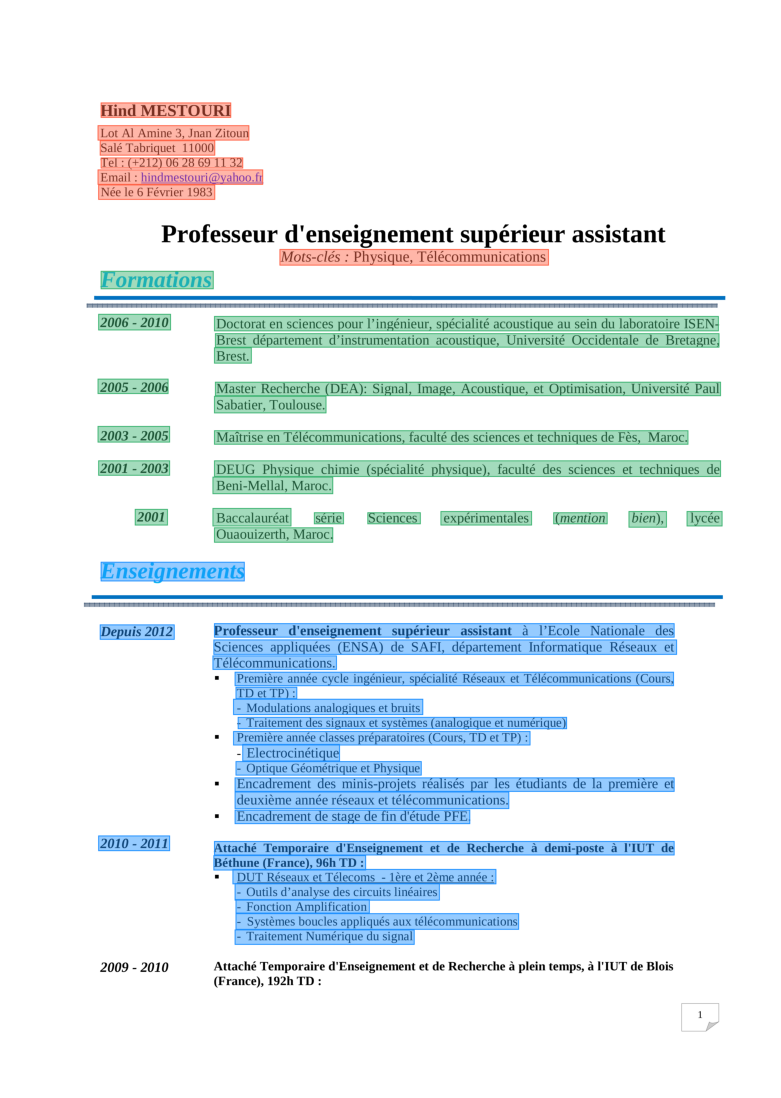

In [ ]:
# @title 🧩 Visual Inference: Predict & Display Resume Sections
import torch, numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
from pathlib import Path

# === 1️⃣ Load your fine-tuned model and processor ===
MODEL_PATH = "/content/layoutlmv3-finetuned-resume"  # or Drive path if saved there
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH).to(device)
processor = LayoutLMv3Processor.from_pretrained(MODEL_PATH, apply_ocr=False)

# === 2️⃣ Choose an image ===
# Option 1: pick one from your dataset
test_image_path = ds["test"][0]["image_path"]

# Option 2: or upload manually
# from google.colab import files
# uploaded = files.upload()
# test_image_path = list(uploaded.keys())[0]

print("📄 Using image:", test_image_path)
image = Image.open(test_image_path).convert("RGB")

# === 3️⃣ Get OCR tokens (already stored in your dataset)
words = ds["test"][0]["words"]
boxes = ds["test"][0]["bboxes"]

# === 4️⃣ Run inference ===
encoding = processor(image, words, boxes=boxes, return_tensors="pt", truncation=True, max_length=512)
for k, v in encoding.items():
    encoding[k] = v.to(device)

with torch.no_grad():
    outputs = model(**encoding)
logits = outputs.logits
pred_ids = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

# Need to align predictions with original words/boxes based on word_ids
word_ids = encoding.word_ids(batch_index=0)
pred_labels = []
pred_boxes = []
prev_word_idx = None
for token_id, word_idx in enumerate(word_ids):
    if word_idx is not None and word_idx != prev_word_idx:
        # Take the prediction for the first token of each word
        pred_labels.append(model.config.id2label[int(pred_ids[token_id])])
        pred_boxes.append(boxes[word_idx])
        prev_word_idx = word_idx

print("✅ Inference complete. Visualizing...")

# === 5️⃣ Visualization ===
def draw_boxes(image, boxes, labels, color_map=None):
    img = image.copy()
    draw = ImageDraw.Draw(img, "RGBA")
    if color_map is None:
        color_map = {
            "HEADER_INFO": (255, 99, 71, 120),
            "EXPERIENCE": (30, 144, 255, 120),
            "EDUCATION": (60, 179, 113, 120),
            "SKILLS": (255, 215, 0, 120),
            "SUMMARY": (186, 85, 211, 120),
            "OTHERS": (128, 128, 128, 120),
        }
    for (label, box) in zip(labels, boxes):
        if label == "O":
            continue
        # Ensure box coordinates are integers before scaling
        x0, y0, x1, y1 = [int(v) for v in box]
        # Scale box coordinates back to original image size
        x0_scaled = int(x0 / 1000 * image.width)
        y0_scaled = int(y0 / 1000 * image.height)
        x1_scaled = int(x1 / 1000 * image.width)
        y1_scaled = int(y1 / 1000 * image.height)

        color = color_map.get(label.split("-")[-1], (255, 0, 0, 120))
        draw.rectangle([x0_scaled, y0_scaled, x1_scaled, y1_scaled], outline=color[:3], width=3, fill=color)
    return img

viz = draw_boxes(image, pred_boxes, pred_labels)
plt.figure(figsize=(10, 14))
plt.imshow(viz)
plt.axis("off")
plt.show()